In [379]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
from scipy import stats

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [272]:
terms = ['breakfast', 'brunch', 'coffee', 'lunch', 'dinner']
columns = ['term', 'time', 'count']
times = np.arange(24)
labels = [
  '12am', '1am', '2am', '3am', '4am', '5am', '6am', '7am', '8am', '9am', '10am', '11am', 
  '12pm', '1pm', '2pm', '3pm', '4pm', '5pm', '6pm', '7pm', '8pm', '9pm', '10pm', '11pm', 
]
colors = {
    'breakfast': '#F29F05',
    'brunch': '#87A61C',
    'coffee': '#AA502D',
    'lunch': '#F25C05',
    'dinner': '#D92526'
}

In [273]:
# create the data frame from csv
df = pd.read_csv('tweets_local_hours.csv', header=None, names=columns)

In [274]:
# create a normalized range for each term
for term in terms:
    tdf = df[df['term'] == term]
    max = tdf['count'].max()
    min = tdf['count'].min()
    
    for index, row in df.iterrows():
        if row['term'] == term:
            df.loc[index, 'normalized'] = ((row['count'] - min) / (max - min) * 100)

In [275]:
# create a pivot table
dfp_time = df.pivot(index='time', columns='term', values='count')
dfp_norm = df.pivot(index='time', columns='term', values='normalized')

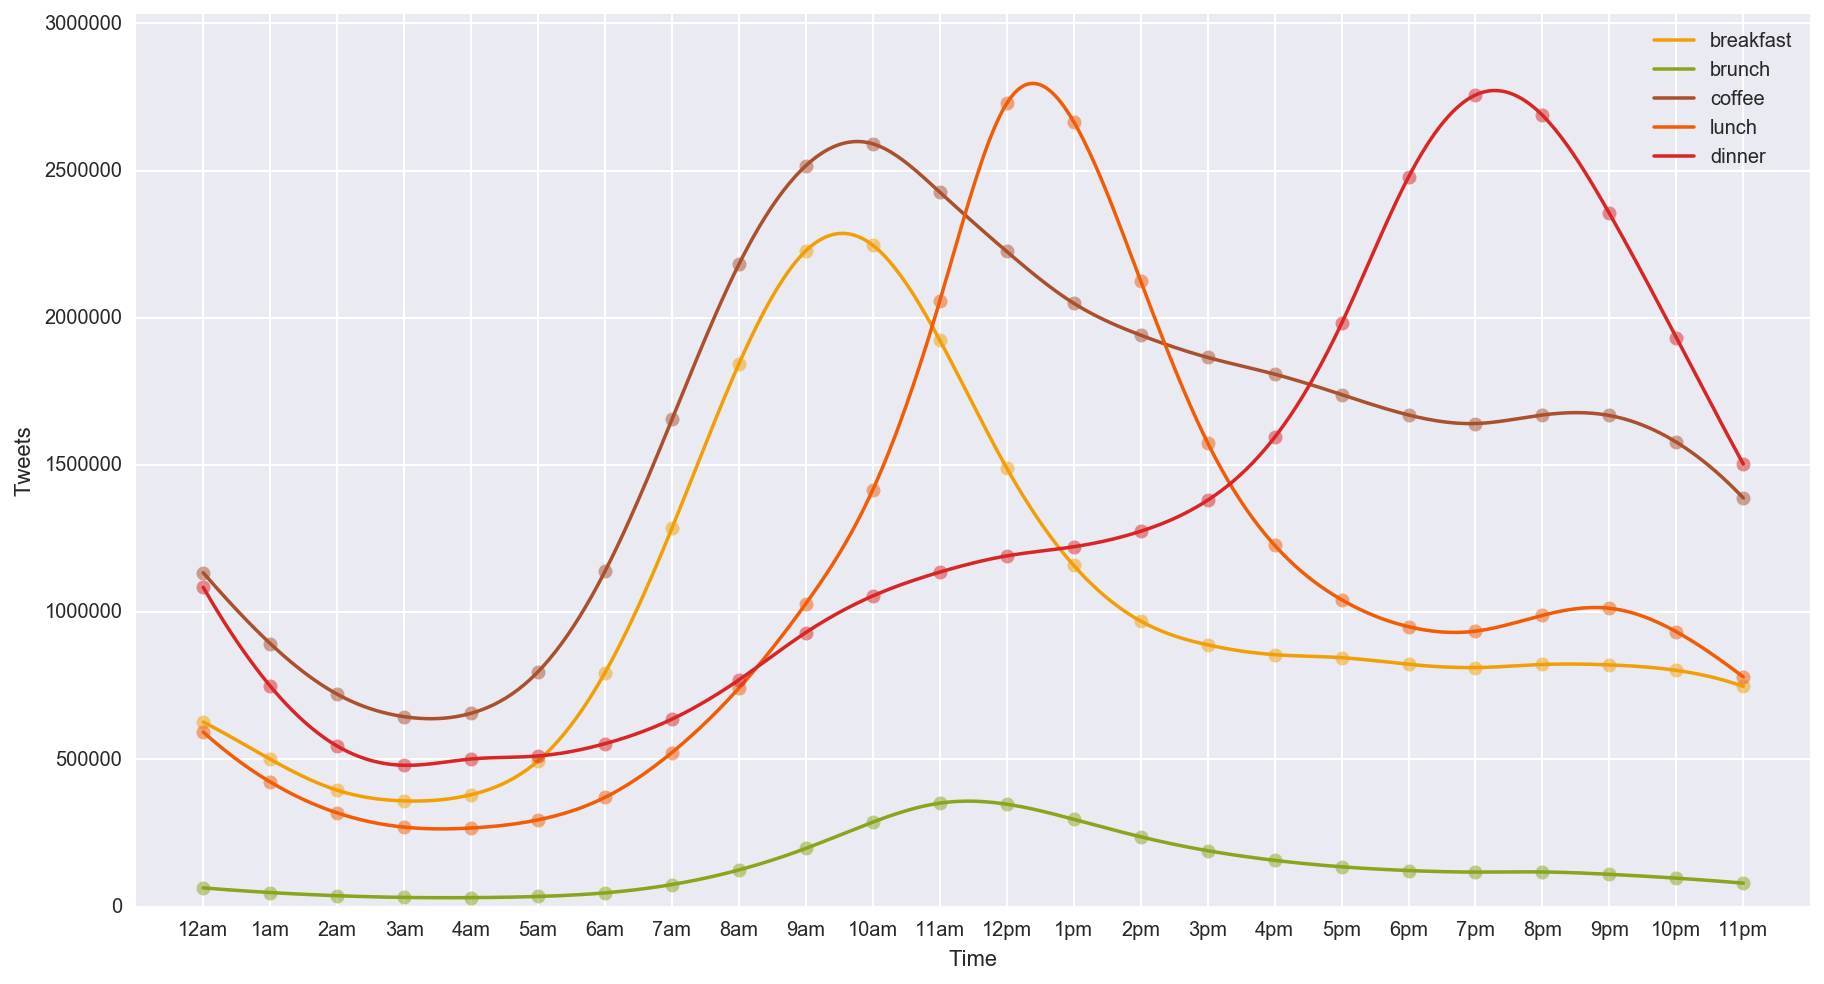

In [276]:
xnew = np.linspace(0, 23, num=500, endpoint=True)

fig=plt.figure(figsize=(15, 8), dpi= 80, facecolor='w', edgecolor='k')

for term in terms:
    spline = UnivariateSpline(times, dfp_time[term], s=0)
    plt.plot(times, dfp_time[term], 'o', color=colors[term], alpha=0.50, label='_nolegend_')
    plt.plot(xnew, spline(xnew), '-', color=colors[term], label=term)
    
plt.ylabel('Tweets')
plt.xlabel('Time')
plt.xlim([-1,24])
plt.ylim([0,df['count'].max() * 1.1])
plt.xticks(times, labels)
plt.legend()
plt.show()


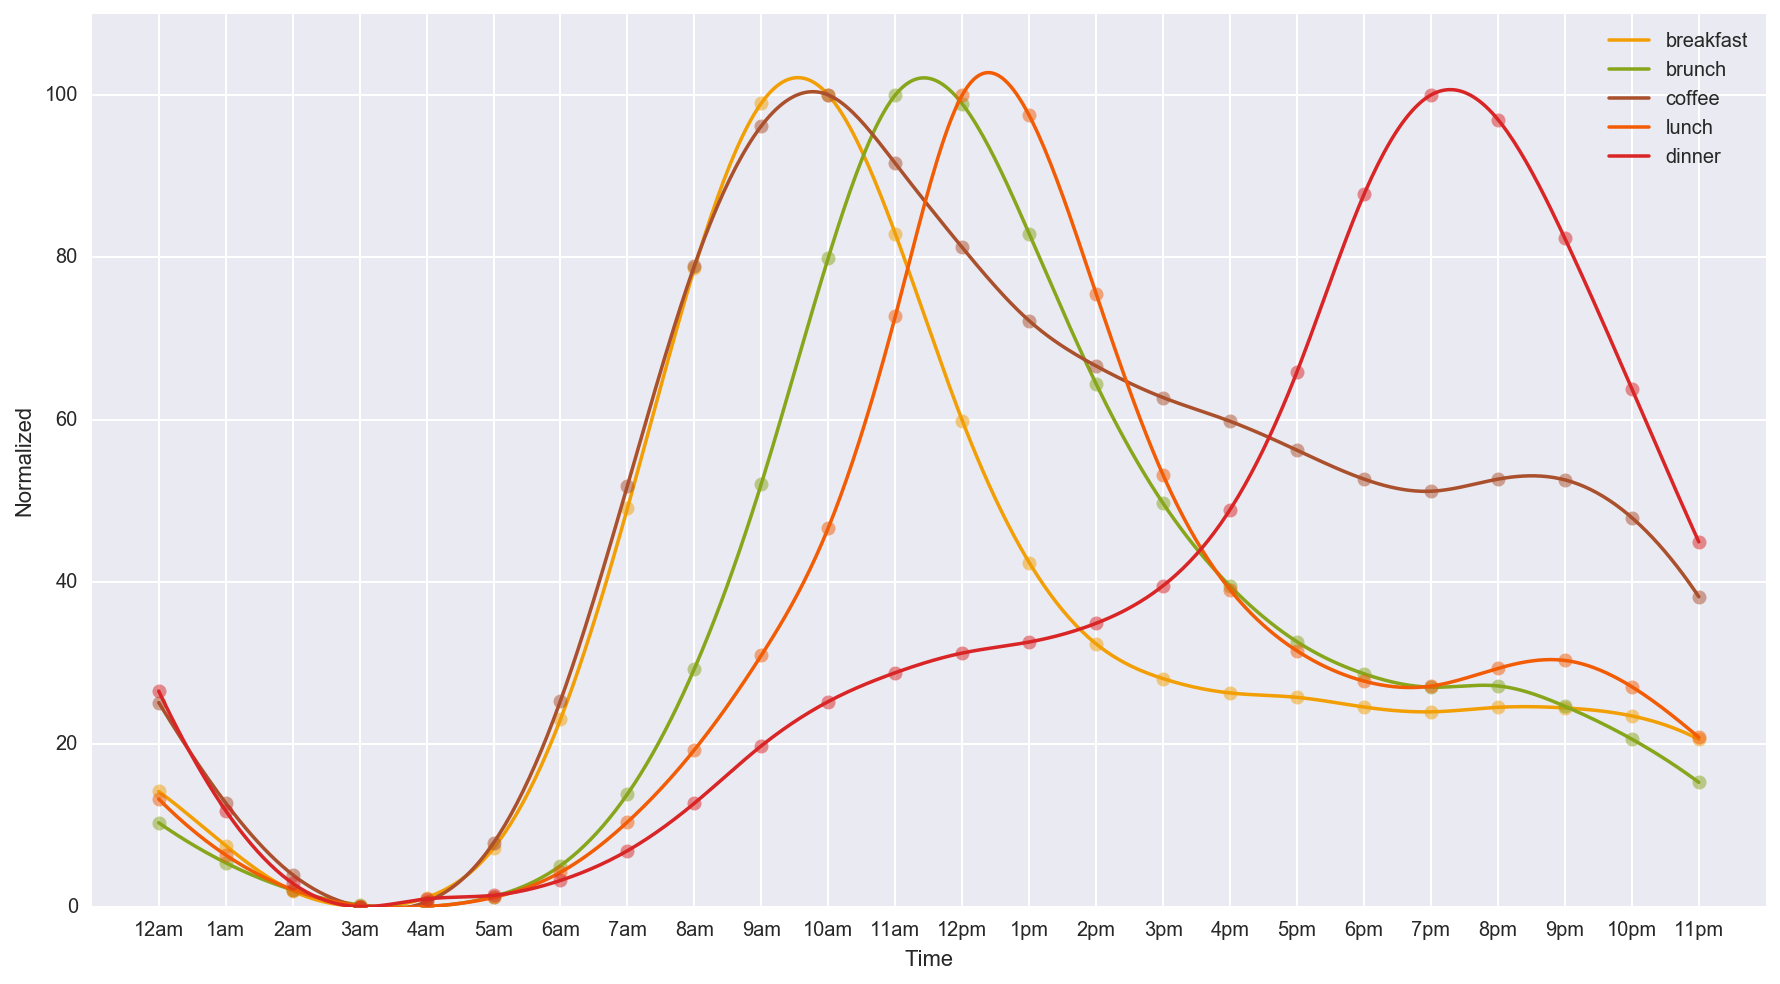

In [277]:
xnew = np.linspace(0, 23, num=500, endpoint=True)
fig=plt.figure(figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')

for term in terms:
    spline = UnivariateSpline(times, dfp_norm[term], s=0)
    plt.plot(times, dfp_norm[term], 'o', color=colors[term], alpha=0.5, label='_nolegend_')
    plt.plot(xnew, spline(xnew), '-', color=colors[term], label=term)
    
plt.ylabel('Normalized')
plt.xlabel('Time')
plt.xlim([-1,24])
plt.ylim([0,110])
plt.xticks(times, labels)
plt.legend()
plt.show()

# Derivates

Hypothesis 1, when the line is at its greatest slope (people are beginning to tweet about it at) is when the timerange begins and when it is at its lowest slope (people are slowing down their tweets) is when it ends.

To find this teimrange we take the derivative of the spline and simeply find the maximum and the minimum.



breakfast
7.32865731463 to 11.4308617234
brunch
9.49498997996 to 13.1823647295
lunch
11.2004008016 to 13.9198396794


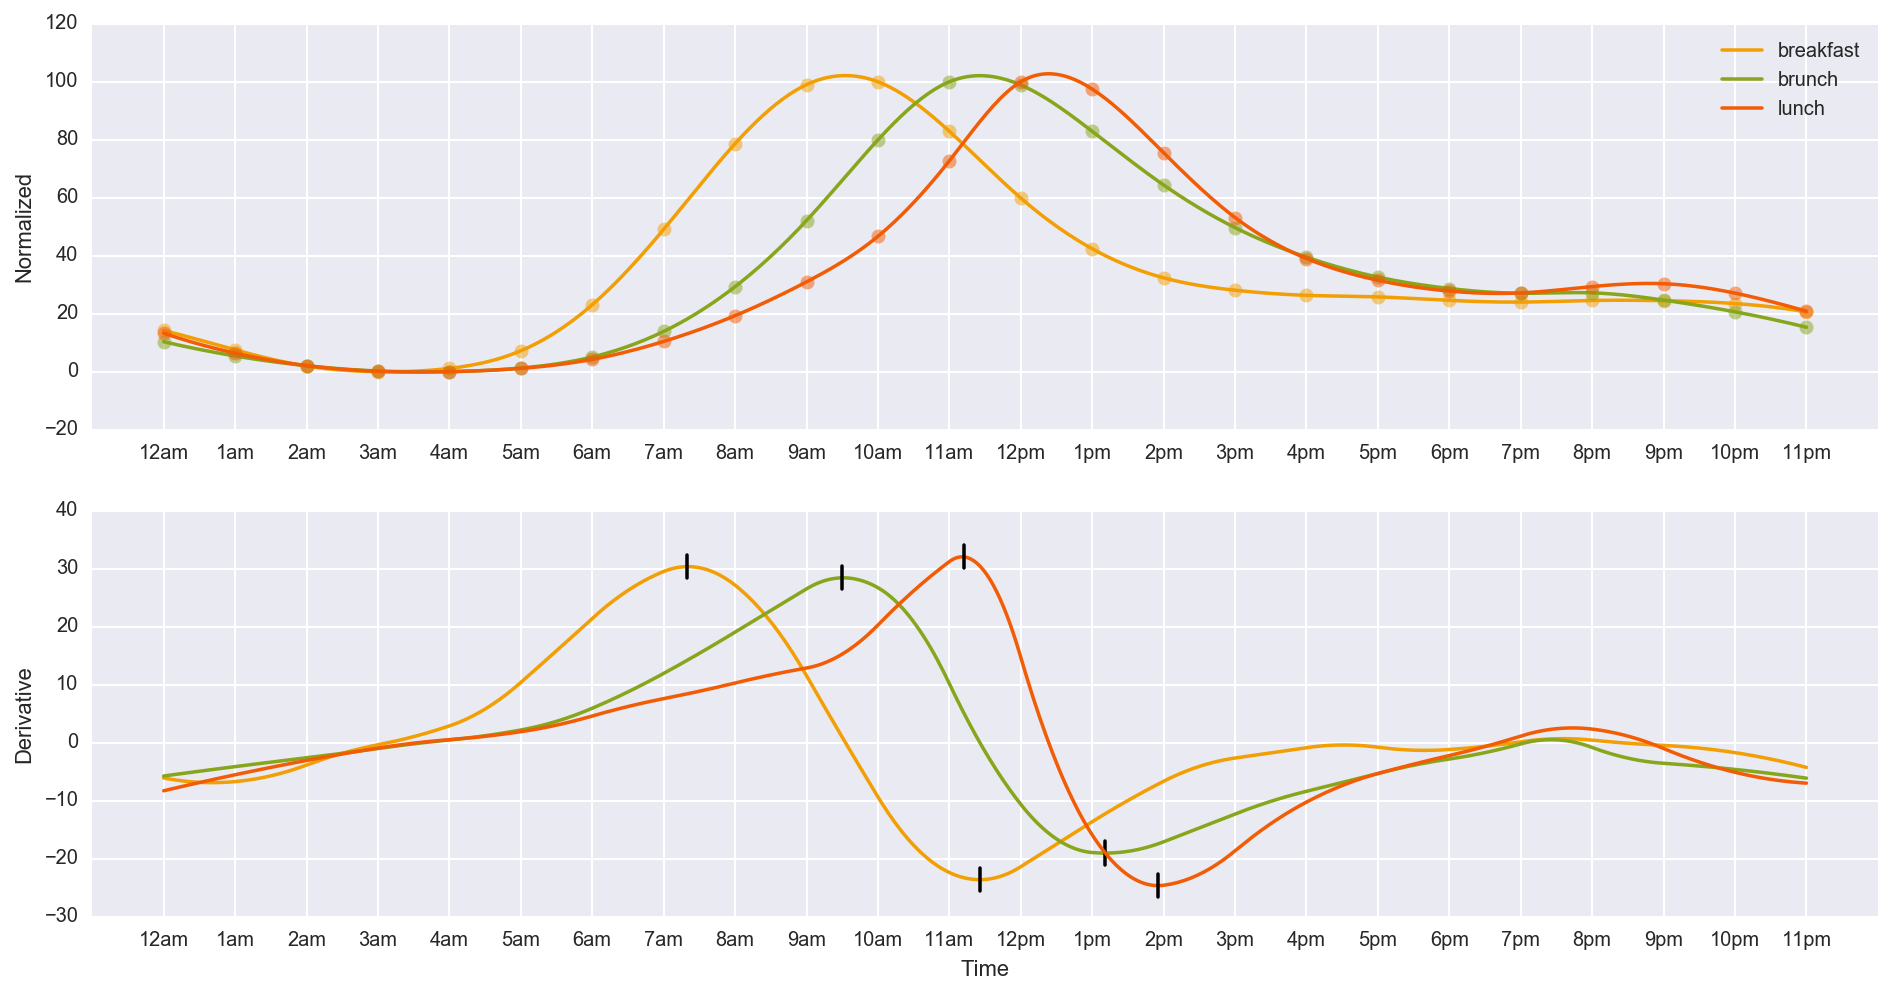

In [316]:
xnew = np.linspace(0, 23, num=500, endpoint=True)
fig = plt.figure(figsize=(16, 8), facecolor='w', edgecolor='k')

plot_terms = ['breakfast', 'brunch', 'lunch'] # terms

plt.subplot(211)
plt.xlim([-1,24])
plt.ylabel('Normalized')
plt.xticks(times, labels)
for term in plot_terms:
    spline = UnivariateSpline(times, dfp_norm[term], s=0)
    plt.plot(times, dfp_norm[term], 'o', color=colors[term], alpha=0.5, label='_nolegend_')
    plt.plot(xnew, spline(xnew), '-', color=colors[term], label=term)

plt.legend()
    
plt.subplot(212)
plt.xlim([-1,24])
plt.xticks(times, labels)
plt.ylabel('Derivative')
plt.xlabel('Time')
for term in plot_terms:
    spline = UnivariateSpline(times, dfp_norm[term], s=0)
    d = spline.derivative()(xnew)
    plt.plot(xnew, d, '-', color=colors[term])
    # plot black bars
    plt.plot((xnew[np.argmax(d, axis=0)], xnew[np.argmax(d, axis=0)]), 
             (d[np.argmax(d, axis=0)] - 2, d[np.argmax(d, axis=0)] + 2), 'k-')
    plt.plot((xnew[np.argmin(d, axis=0)], xnew[np.argmin(d, axis=0)]),
             (d[np.argmin(d, axis=0)] - 2, d[np.argmin(d, axis=0)] + 2), 'k-')
    
    print(term)
    print(xnew[np.argmax(d, axis=0)], 'to', xnew[np.argmin(d, axis=0)])

# plt.subplot(211)
# plt.xlim([-1,24])
# plt.xticks(times, labels)
# plt.ylabel('Term')
# plt.xlabel('Time')
# plt.yticks(np.arange(0,len(plot_terms)), plot_terms)
# for term in plot_terms:
#     plt.hlines(plot_terms, xnew[np.argmax(d, axis=0)], xnew[np.argmin(d, axis=0)])
#     print(term)
    
    
plt.show()

dinner
lunch
brunch
breakfast


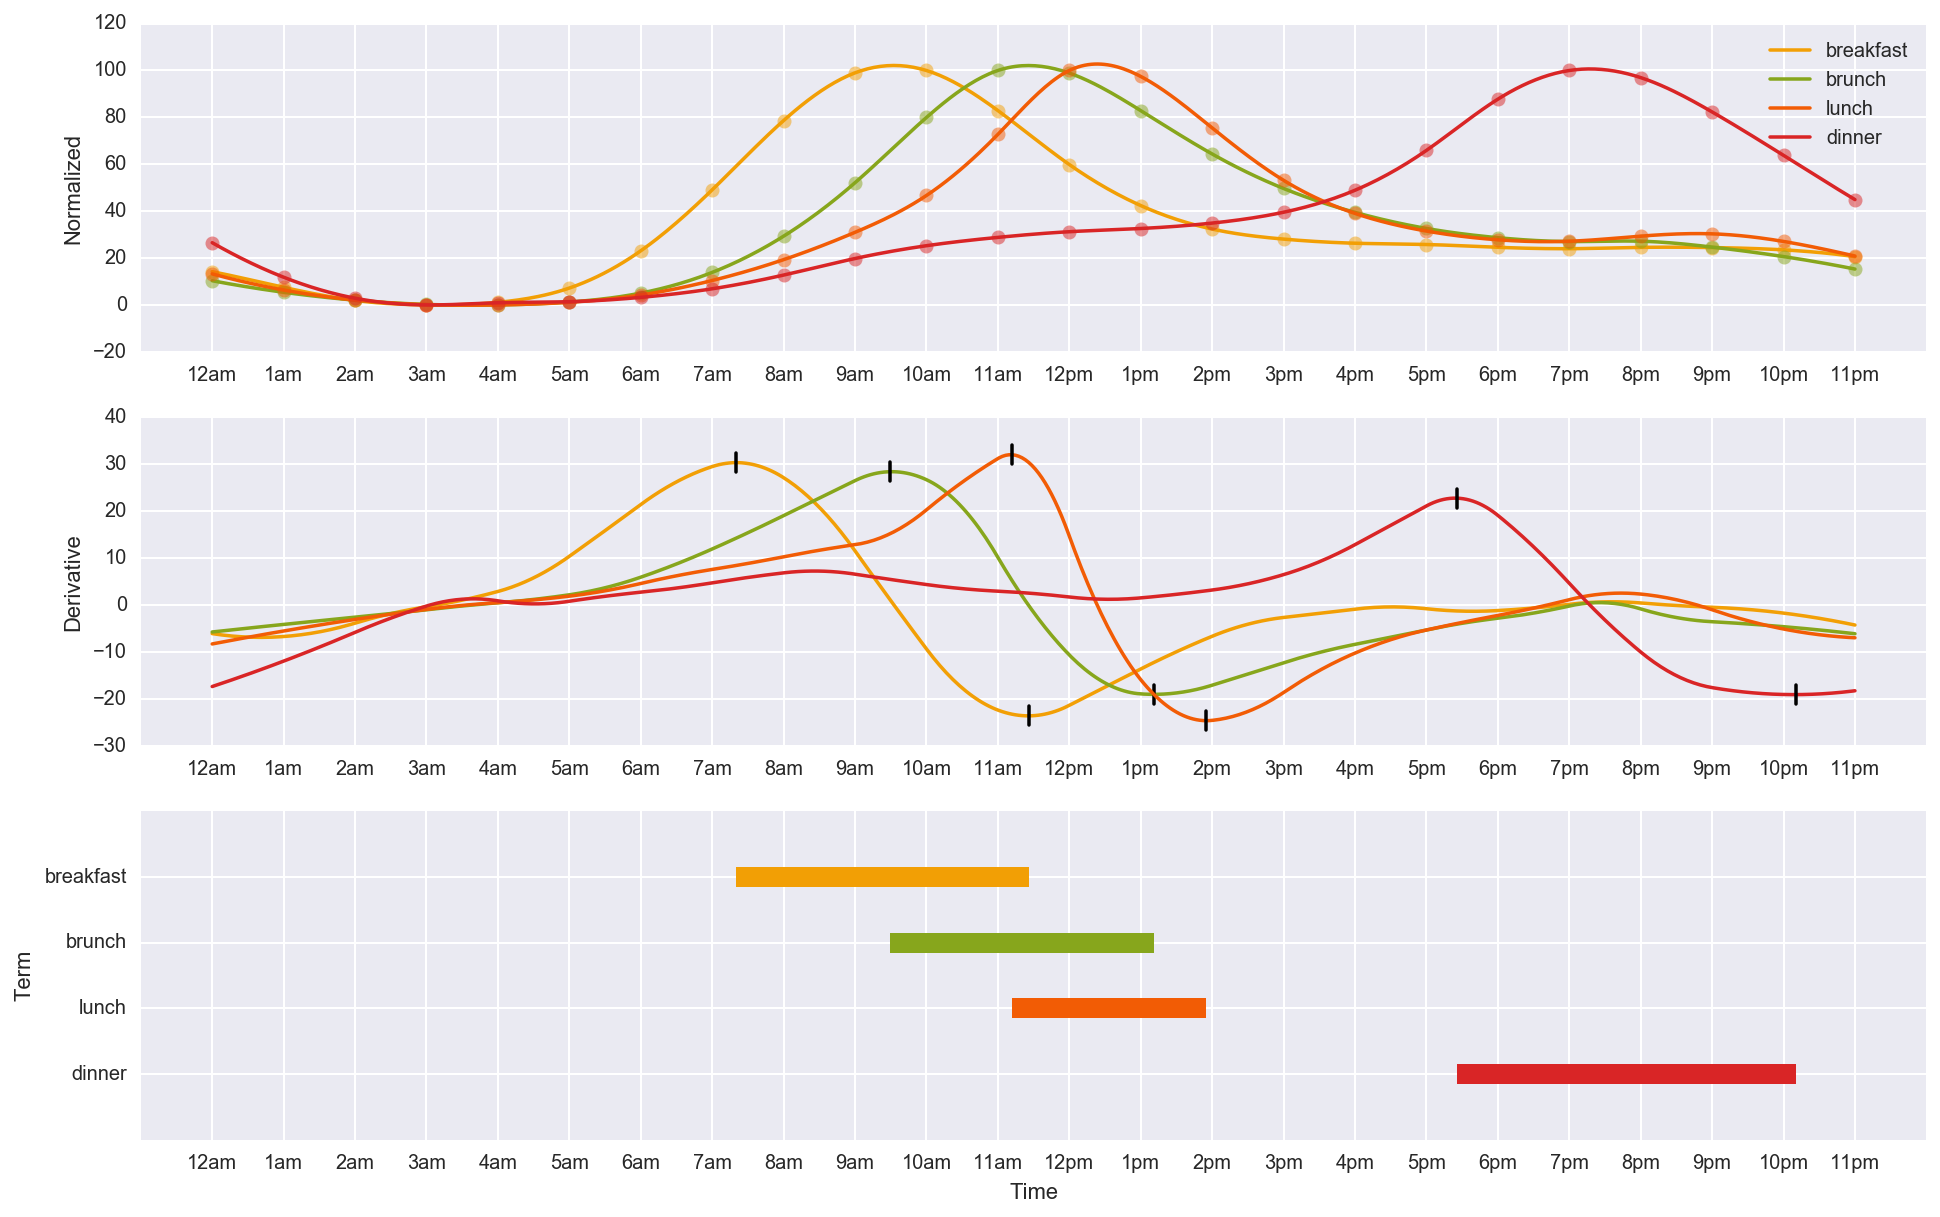

In [380]:
from matplotlib import gridspec

xnew = np.linspace(0, 23, num=500, endpoint=True)
fig = plt.figure(figsize=(16, 8), facecolor='w', edgecolor='k')

plot_terms = ['breakfast', 'brunch', 'lunch', 'dinner'] # terms

fig = plt.figure(figsize=(16, 10), facecolor='w', edgecolor='k')

gs = gridspec.GridSpec(3, 3)
ax1 = fig.add_subplot(gs[0,:])
ax2 = fig.add_subplot(gs[1,:])
ax3 = fig.add_subplot(gs[2,:])
# f, axarr = plt.subplots(3, sharex=True)

plt.sca(ax1)

plt.xlim([-1,24])
plt.xticks(times, labels)
plt.xticks(times, labels)
plt.ylabel('Normalized')
for term in plot_terms:
    spline = UnivariateSpline(times, dfp_norm[term], s=0)
    plt.plot(times, dfp_norm[term], 'o', color=colors[term], alpha=0.5, label='_nolegend_')
    plt.plot(xnew, spline(xnew), '-', color=colors[term], label=term)
    
    
# box = ax1.get_position()
# ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.legend()

# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -10),
#           fancybox=True, shadow=True, ncol=5)

# # axarr[0].legend()
    
plt.sca(ax2)
plt.xlim([-1,24])
plt.xticks(times, labels)
plt.xticks(times, labels)
plt.ylabel('Derivative')

# # plt.subplot(212)
# # plt.xlim([-1,24])
# plt.xticks(times, labels)
# plt.ylabel('Derivative')
for term in plot_terms:
    spline = UnivariateSpline(times, dfp_norm[term], s=0)
    d = spline.derivative()(xnew)
    plt.plot(xnew, d, '-', color=colors[term])
    # plot black bars
    plt.plot((xnew[np.argmax(d, axis=0)], xnew[np.argmax(d, axis=0)]), 
             (d[np.argmax(d, axis=0)] - 2, d[np.argmax(d, axis=0)] + 2), 'k-')
    plt.plot((xnew[np.argmin(d, axis=0)], xnew[np.argmin(d, axis=0)]),
             (d[np.argmin(d, axis=0)] - 2, d[np.argmin(d, axis=0)] + 2), 'k-')
    
# #     print(term)
# #     print(xnew[np.argmax(d, axis=0)], 'to', xnew[np.argmin(d, axis=0)])


plt.sca(ax3)
plt.xlim([-1,24])
plt.xticks(times, labels)
plt.xticks(times, labels)
plt.yticks(range(len(plot_terms)), reversed(plot_terms))
plt.ylim([-1,len(plot_terms)])
plt.ylabel('Term')
for i, term in enumerate(reversed(plot_terms)):
    spline = UnivariateSpline(times, dfp_norm[term], s=0)
    d = spline.derivative()(xnew)
    plt.hlines(i, xnew[np.argmax(d, axis=0)], xnew[np.argmin(d, axis=0)], linewidth=10, color=colors[term], label=term)
    print(term)

plt.xlabel('Time')
plt.show()